In [82]:
import numpy as np
import matplotlib.pyplot as plt
import math
from sklearn import datasets
from sklearn.preprocessing import normalize

POINT_N = 300
DIM_N = 2
CLUST_N = 4
CLUSTER_TO_COLOR = {
    0:(1, 0, 0),
    1:(0, 1, 0),
    2:(0, 0, 1),
    3:(1, 1, 0)
}

class RunMode:
    train = 0
    test = 1

class NNet:
    def __init__(self, dim, clust_number):
        self.layers_number = 2
        self.dim = dim 
        self.clust_number = clust_number  
        self.weights = 0.1 * np.random.rand(clust_number, dim)
        self.biases = np.zeros(clust_number, dtype=float)

    A = 1.0
    def activation_function(self, x):
        # return 1.0 / (1.0 + np.exp(-self.A*x))
        return np.exp(x)
    
    def dist_func(self, x, y):
        return np.exp(-self.D*np.dot((x - y), (x - y)))
        
    H = 0.01
    D = 0.1
    def run(self, points, centers = None):
        dw = np.zeros([self.clust_number, self.dim], dtype=float)
        db = np.zeros(self.clust_number, dtype=float)
        result = []
        sum_loss = 0.0
        for point in range(points.shape[0]):
            pred = np.dot(self.weights, points[point]) + self.biases
            result.append(pred)
            norm = sum(self.activation_function(pred))
            loss = 0.0
            for clust in range(self.clust_number):
                loss += self.activation_function(pred[clust])/norm * self.dist_func(points[point], centers[clust])
            dtmp = np.empty(self.clust_number, dtype=float)
            for clust in range(self.clust_number):
                dtmp[clust] = self.activation_function(pred[clust])/norm * (self.dist_func(points[point], centers[clust]) - loss)
            db += dtmp
            for clust in range(self.clust_number):
                for dim in range(self.dim):
                    dw[clust][dim] += dtmp[clust] * points[point][dim]
            sum_loss += loss
        self.weights += self.H * dw
        self.biases += self.H * db
        return (np.array(result), (dw ** 2).sum() * self.H**2, (db ** 2).sum() * self.H**2)

763


C:\Users\ymayma\AppData\Local\Temp\ipykernel_2840\334088782.py:21: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  axes[0].scatter(point[0], point[1], c = CLUSTER_TO_COLOR[res[i].argmax()], marker='o')
C:\Users\ymayma\AppData\Local\Temp\ipykernel_2840\334088782.py:25: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  axes[1].scatter(point[0], point[1], c = CLUSTER_TO_COLOR[target[i].argmax()], marker='o')


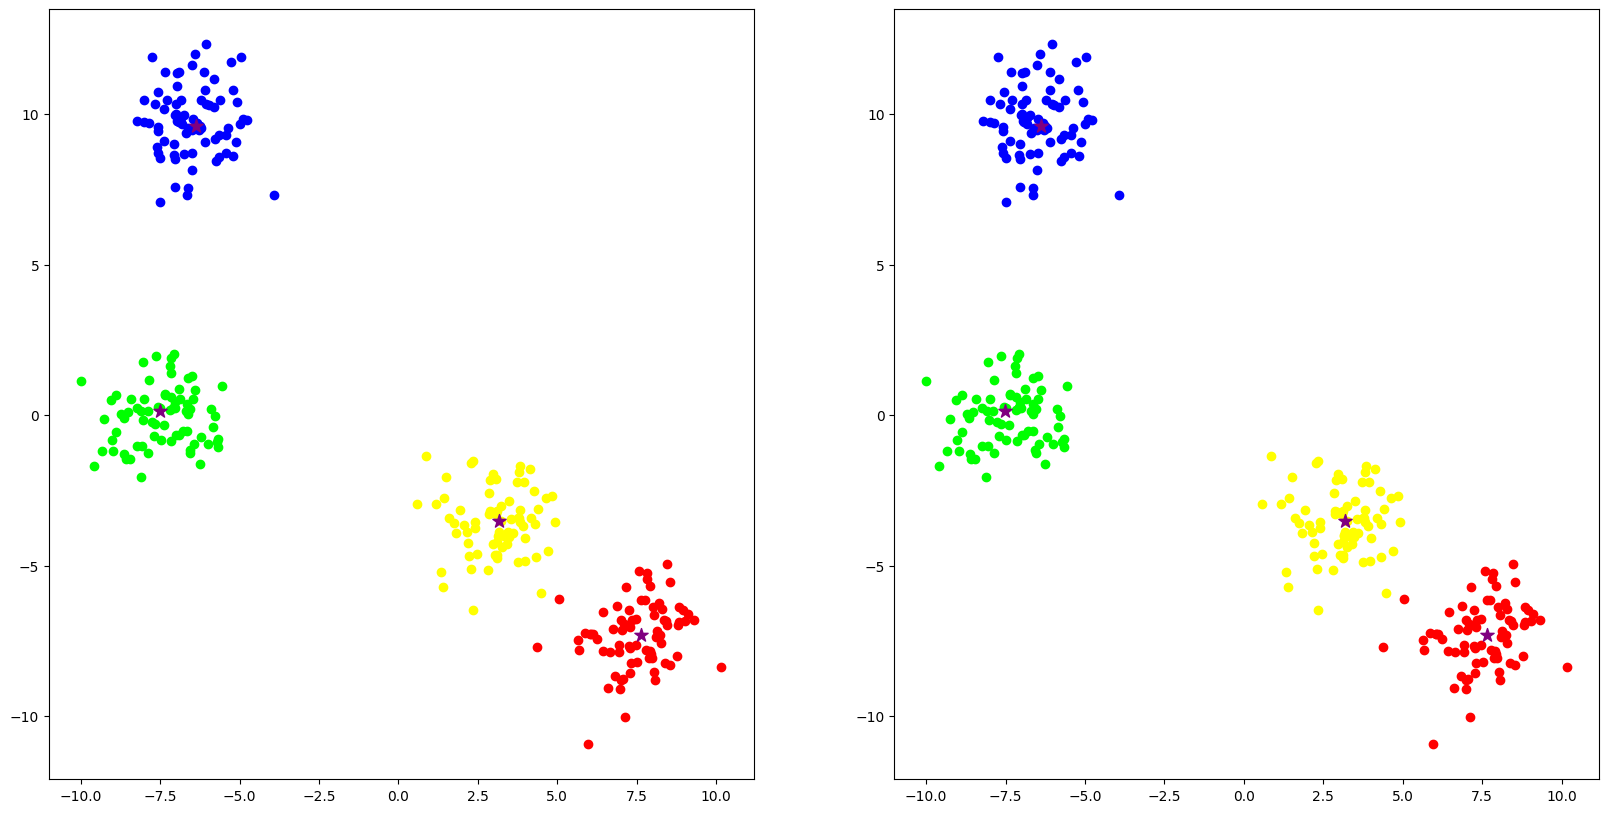

In [84]:
from math import exp
data, target, centers = datasets.make_blobs(n_samples=POINT_N, centers=CLUST_N, n_features=DIM_N, center_box=(-10,10), return_centers=True)

def distance(point1, point2):
    return np.dot((point1 - point2), (point1 - point2))

target = np.array([np.array([int(target[n]==i) for i in range(CLUST_N)]) for n in range(POINT_N)])

net = NNet(DIM_N,CLUST_N)
eps = 3e-3
dbSquare, dwSquare = 1, 1
i = 0 

while ((dwSquare > eps ** 2 or dbSquare > eps **2) and i < 1000):
    res, dwSquare, dbSquare = net.run(data, centers)
    i += 1
print(i)

fig, axes = plt.subplots(1,2, figsize=(20,10))
for i, point in enumerate(data):
    axes[0].scatter(point[0], point[1], c = CLUSTER_TO_COLOR[res[i].argmax()], marker='o')
axes[0].scatter(centers[:,0], centers[:,1], c='purple', marker="*", s=100)

for i, point in enumerate(data):
    axes[1].scatter(point[0], point[1], c = CLUSTER_TO_COLOR[target[i].argmax()], marker='o')
axes[1].scatter(centers[:,0], centers[:,1], c='purple', marker="*", s=100)

In [113]:
import pandas as pd
from sklearn import preprocessing

def prepare_data(dataset_name, sep, targ_name):
    data = pd.read_csv(dataset_name, sep=sep)
    data = data.dropna()
    targ = pd.DataFrame(data[targ_name])
    features = data.drop([targ_name], axis = 1)
    features = (features-features.mean())/features.std()
    features = ((features - features.mean())/features.std()).to_numpy()
    ordinal_encoder = preprocessing.OrdinalEncoder(dtype=int)
    targ = pd.DataFrame(ordinal_encoder.fit_transform(targ), columns=targ.columns)
    points_number = len(features)
    cluster_number = len(targ.value_counts())
    centers = []
    for a in targ[targ_name].unique():
        n = len(targ[targ[targ_name] == a].index)
        centers.append(features[targ[targ[targ_name] == a].index].sum(axis = 0)/n)
    features_number = features.shape[1]
    targ = np.array([np.array([int(targ[targ_name][n]==i) for i in range(cluster_number)]) for n in range(points_number)])
    return features, np.array(centers), targ, points_number, cluster_number, features_number

In [116]:
features, centers, targ, points_number, cluster_number, features_number = prepare_data('fake_bills.csv', ';', 'is_genuine')
centers = centers[::-1]
net = NNet(features_number, cluster_number)
for _ in range(100):
    res, _, _ = net.run(features, centers)
    print(f"Точность - {round((res.argmax(axis = 1) == targ.argmax(axis = 1)).sum() / points_number * 100, 1)} %")

Точность - 38.4 %
Точность - 97.9 %
Точность - 98.1 %
Точность - 98.3 %
Точность - 98.4 %
Точность - 98.4 %
Точность - 98.4 %
Точность - 98.6 %
Точность - 98.6 %
Точность - 98.6 %
Точность - 98.7 %
Точность - 98.7 %
Точность - 98.8 %
Точность - 98.8 %
Точность - 98.8 %
Точность - 98.8 %
Точность - 98.8 %
Точность - 98.8 %
Точность - 98.8 %
Точность - 98.8 %
Точность - 98.8 %
Точность - 98.8 %
Точность - 98.8 %
Точность - 98.8 %
Точность - 98.8 %
Точность - 98.8 %
Точность - 98.9 %
Точность - 98.9 %
Точность - 98.9 %
Точность - 98.9 %
Точность - 98.9 %
Точность - 98.9 %
Точность - 98.9 %
Точность - 98.9 %
Точность - 98.9 %
Точность - 98.9 %
Точность - 98.9 %
Точность - 98.9 %
Точность - 98.9 %
Точность - 98.9 %
Точность - 98.8 %
Точность - 98.8 %
Точность - 98.8 %
Точность - 98.8 %
Точность - 98.8 %
Точность - 98.8 %
Точность - 98.8 %
Точность - 98.8 %
Точность - 98.8 %
Точность - 98.8 %
Точность - 98.8 %
Точность - 98.8 %
Точность - 98.8 %
Точность - 98.8 %
Точность - 98.8 %
Точность -

In [118]:
features, centers, targ, points_number, cluster_number, features_number = prepare_data('Pistachio.csv', ',', 'Class')

net = NNet(features_number, cluster_number)
for _ in range(300):
    res, _, _ = net.run(features, centers)
    print(f"Точность - {round((res.argmax(axis = 1) == targ.argmax(axis = 1)).sum() / points_number * 100, 1)} %")

Точность - 62.8 %
Точность - 85.5 %
Точность - 85.8 %
Точность - 85.8 %
Точность - 85.9 %
Точность - 85.8 %
Точность - 85.9 %
Точность - 85.9 %
Точность - 85.9 %
Точность - 85.9 %
Точность - 85.8 %
Точность - 85.8 %
Точность - 85.8 %
Точность - 85.8 %
Точность - 85.9 %
Точность - 85.8 %
Точность - 85.8 %
Точность - 85.7 %
Точность - 85.7 %
Точность - 85.7 %
Точность - 85.7 %
Точность - 85.8 %
Точность - 85.8 %
Точность - 85.8 %
Точность - 85.8 %
Точность - 85.8 %
Точность - 85.9 %
Точность - 85.8 %
Точность - 85.8 %
Точность - 85.8 %
Точность - 85.8 %
Точность - 85.8 %
Точность - 85.8 %
Точность - 85.8 %
Точность - 85.8 %
Точность - 85.9 %
Точность - 85.8 %
Точность - 85.8 %
Точность - 85.8 %
Точность - 85.8 %
Точность - 85.8 %
Точность - 85.8 %
Точность - 85.8 %
Точность - 85.9 %
Точность - 85.9 %
Точность - 85.9 %
Точность - 85.9 %
Точность - 86.0 %
Точность - 85.9 %
Точность - 85.9 %
Точность - 85.9 %
Точность - 85.9 %
Точность - 85.9 %
Точность - 85.9 %
Точность - 86.0 %
Точность -